# Applied Materials: Data Challenge
### Author: Jiayin Guo
### March 28, 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

sns.set(style='white', context='notebook', palette='deep')

## Part 1) Data Describtion

In [2]:
# Load dataset
df = pd.read_csv("HR_comma_sep.csv")

In [3]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
df.shape

(14999, 10)

In [5]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


__Data Describtion__:

There's no missing feilds in any column, no need for imputation. 

The dataset contains a total of 14999 obserbations and 10 columns. <br>
The granularity of the data is clear: every observation represents one employee of the company. <br>
The `left` column is our reasearch target, with 1 indicating employee leaving and 0 indicating employee staying; within the other 9 columns(features), 3 of them are categorical: `department`, `salary`, the rest 6 are numerical.

In the following analysis, two questions are approached:<br>
- Why are company's best and most experienced employees leaving prematurely?
- What recommendations can we make to improve employee retention?

## Part 2) EDA: Data Understading

### 1.1 ) Q1: What are the relationships between the target and the features?

__Numerical variables and left status__

In [7]:
# numerical variables
num_var = df.select_dtypes(exclude=['object']).columns.tolist()
num_var.remove('left')
num_var

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years']

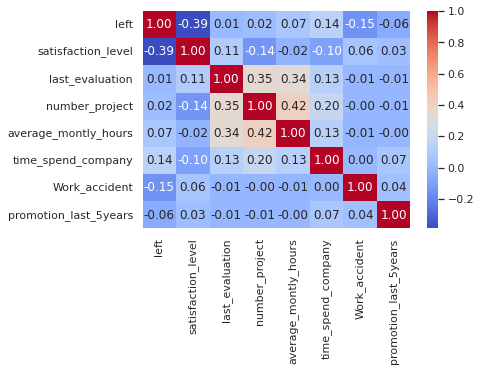

In [8]:
# Correlation Matrix between numerical values and `left`
num_var.insert(0,'left')
g = sns.heatmap(df[num_var].corr(), annot=True, fmt='.2f', cmap='coolwarm');

###

Among the numerical features, satisfaction level has the most significative correlation with the left probabilit, time spend at the company and work accident also seem to play an important role. More detailed exploration is needed.

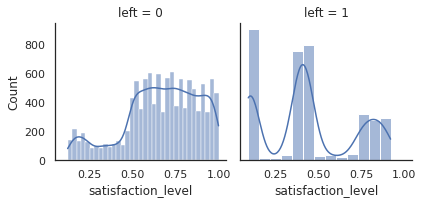

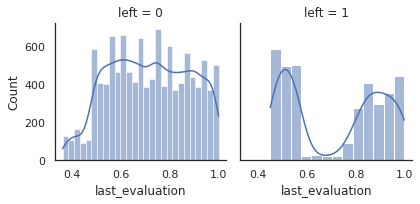

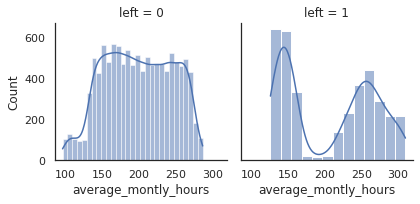

In [9]:
# continous features: satisfaction_level, evaluation and average montly hours
# plot the relationship between the contious feature and the whether the employee has left

for feature in ["satisfaction_level", "last_evaluation", "average_montly_hours"]:
    g = sns.FacetGrid(df, col="left")
    g = g.map(sns.histplot, feature, kde=True)

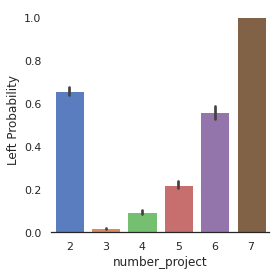

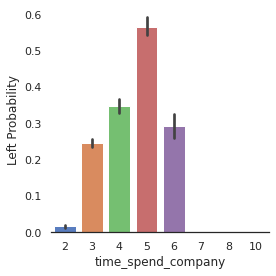

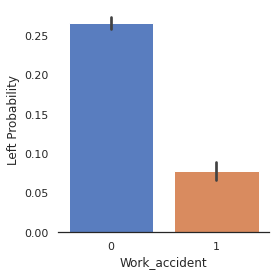

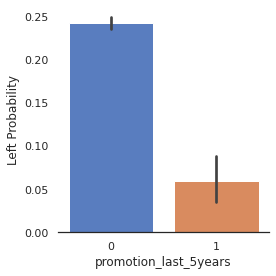

In [10]:
# discret features: number of project, time spend at company, work accident and promotion
# plot the relationship between the discrete feature and the left probability

for feature in ["number_project", "time_spend_company", "Work_accident", "promotion_last_5years"]:
    g = sns.catplot(x=feature, y="left", data=df, kind="bar", height = 4 , palette = "muted")
    g.despine(left=True)
    g = g.set_ylabels("Left Probability")

__Comment:__<br>
From the visulations there are some interesting findings: 
1. While within those who stay at the company, most of them have satisfication level more than 0.5, those who left either are extremely not satisfied (below 0.5, a lot below 0.2) or are very satisfied (above 0.75);
2. The worst and best employees both tend to leave: those who earn very high evaluation score left as well as those who earn very low score;
3. The lazies and the most hard-working employees both tend to leave: the left employees either have extremely high working hours/number of project or extremely low, those who have average working load stay;
4. Having had a work accident lower the leaving probability;
5. Having had a promotion in the past lower the leaving probability.

__Categorical variables and left status__

In [11]:
# categorical variables
cat_var = df.select_dtypes(include=['object']).columns.tolist()
cat_var

['department', 'salary']

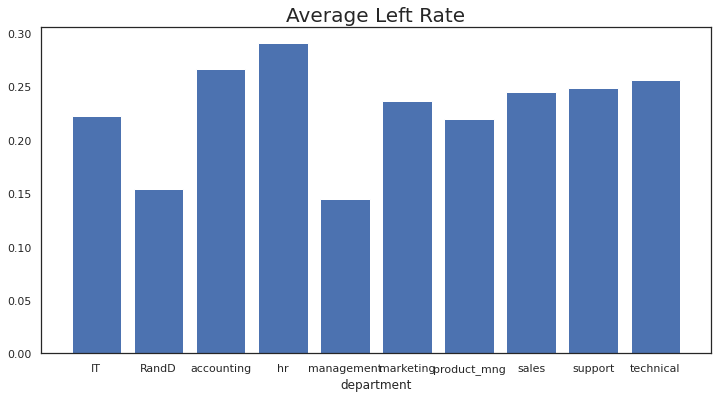

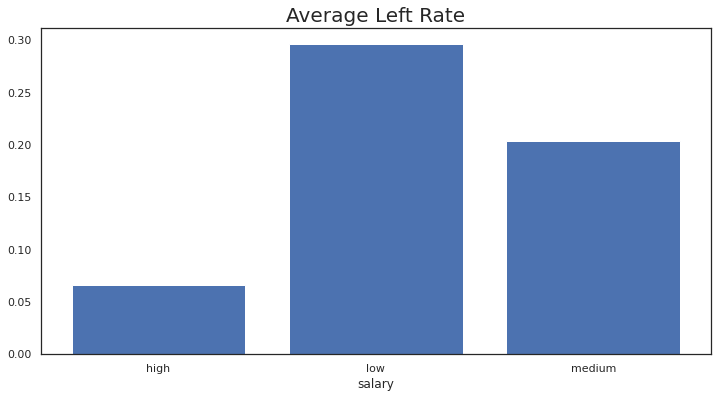

In [12]:
# plot the mean left rate and the categories
from matplotlib.pyplot import figure
for feature in cat_var:
    left = df[[feature, "left"]].groupby(feature).mean().reset_index()
    plt.figure(figsize=(12, 6))
    plt.bar(left[feature], height=left["left"])
    plt.xlabel(feature)
    plt.title("Average Left Rate", fontsize=20);

__Comment:__<br>
1. The HR and the accounting departments have high leaving average rate while the management and RandD departments have the lowest leaving rates;
2. It's clear that higher the salary, lower the leaving rate.

<br>


### 1.2) Q2: What are important relationships between features?

__Highly correlated features__

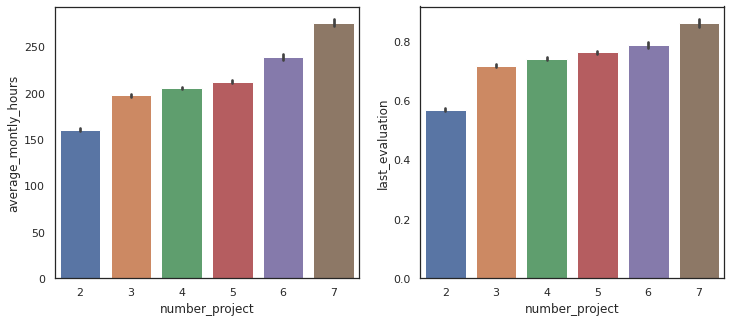

In [13]:
# recall the heat map, there are a high correlation between some numerical variables
# number of project versus average montly hours and evaluation score
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(data=df, x="number_project", y="average_montly_hours", ax=ax[0], )
sns.barplot(data=df, x="number_project", y="last_evaluation", ax=ax[1]);

__Satisfaction Level__

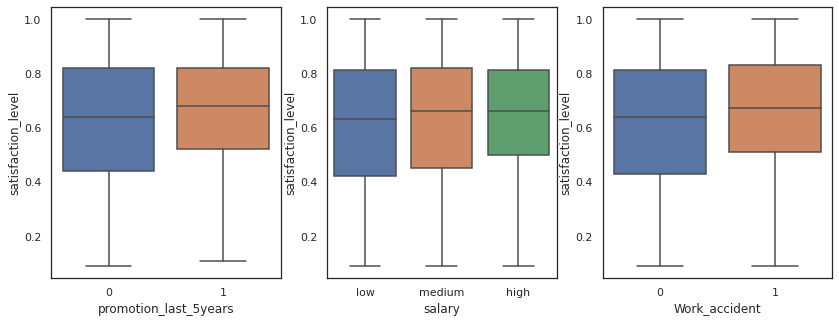

In [14]:
# Satisfaction level 
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
sns.boxplot(data=df, x='promotion_last_5years', y='satisfaction_level', ax=ax[0]);
sns.boxplot(data=df, x='salary', y='satisfaction_level', ax=ax[1]);
sns.boxplot(data=df, x='Work_accident', y='satisfaction_level', ax=ax[2]);

__Salary__

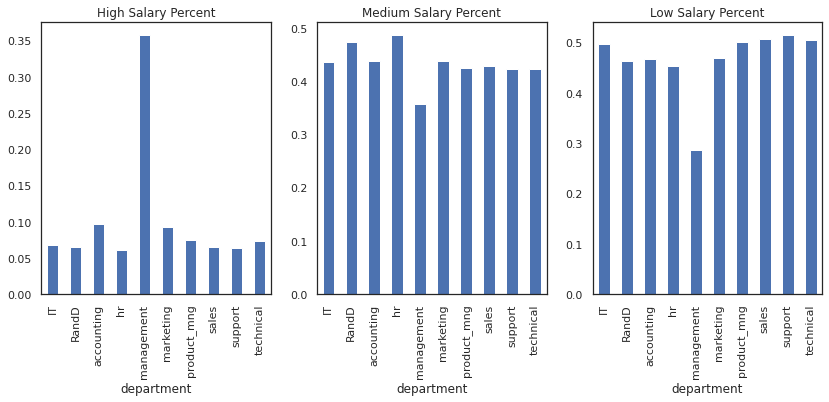

In [15]:
# Salary and department
dep_salary = pd.crosstab(index=df['department'],columns=df['salary'])
dep_salary["total"] = dep_salary["high"] + dep_salary["low"] + dep_salary["medium"]
dep_salary["high%"] = dep_salary["high"]/dep_salary["total"]
dep_salary["low%"] = dep_salary["low"]/dep_salary["total"]
dep_salary["medium%"] = dep_salary["medium"]/dep_salary["total"]

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
dep_salary["high%"].plot.bar(ax=ax[0], title="High Salary Percent")
dep_salary["medium%"].plot.bar(ax=ax[1], title="Medium Salary Percent")
dep_salary["low%"].plot.bar(ax=ax[2], title="Low Salary Percent");

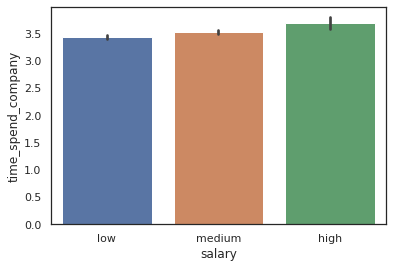

In [16]:
# Salary and time spend at company
sns.barplot(data=df, y='time_spend_company', x='salary');

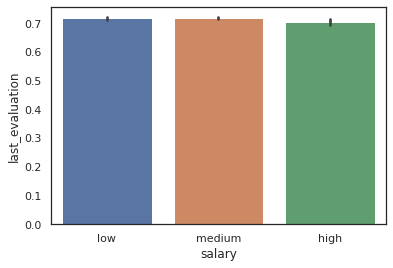

In [17]:
# salary and evaluation score
sns.barplot(data=df, x='salary', y='last_evaluation');

__Comment:__<br>
There are some interesting findings about the inner relationship between the features:
1. Evaluation score, number of projects and average working hours are highly correlated: those have more projects to do tend to work longer and get a higher evaluation score. In this sense, the evaluation score is some how a measure of "laziness".
2. Those who gets promotion in the last 5 years clearly have higher satisfaction level towards the company. Salary also plays a role: less salary, less satisfication. Besides, interestingly, having had a work accident improves the level of satisfication...
3. Salary, naturely, gets higher when your postion gets higher and longer your staying: those in the management position and stay the longest have the highest chance of getting a high salary. Also interestingly, those who gets high salary tend to have slightly lower evaluation score. 

### 1.3) Q3: What are the key statistics or findings relevant to sovling the problems?

Combining the two parts above, here are some key findins to carry on to the modeling part:<br>
1. The `satisfaction_level` is the most correlated numeric feature to our target. Those who are least satisfied as well as those who are most satisfied both tend to leave.  
2. The two descrite variables `promotion` and `Work_accident`, although the correlation scroes are low, have clear relationship with left rate. In the feature engieering part, instead of treating them as numerical variables, it's better to OHE them and make them categorical. 
3. The three features `last_evaluation`, `number_project`, `average_montly_hours` are highly related, together, they can be interpreted as the measure of hard-working-ness/laziness/work load. It also has a polarized relationship with left rate: those who are least burden and get low evluation score would leave, while those working most hard and get the highest score also tend to leave.
4. `salary` plays an extremely (if not the most) important role in retention rate. Higher salary, lower probability of leaving. It's most related to `department` and `time_spend_company`. 

## Part 3) Modeling: Prediction

### 3.1) Feature Engineering

__check for outliers__

From the EDA part we can already see there are outliers in `satisfaction_level` and `time_spend_company`, but we have also seen that these outliers are cruicial in deciding the left rate. So we do not remove them.

__One-Hot Encoding__

In [18]:
model_df = df.copy()
# make Work_accident and promotion categorical
model_df = pd.get_dummies(model_df, columns = ["Work_accident", "promotion_last_5years"])
# OHE the other two categorical variables
model_df = pd.get_dummies(model_df)
model_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_0,Work_accident_1,promotion_last_5years_0,promotion_last_5years_1,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0


__Standarization__

In [19]:
for feature in model_df.iloc[:, 0:5]:
    model_df[feature] = (model_df[feature] - np.mean(model_df[feature]))/np.std(model_df[feature])
model_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_0,Work_accident_1,promotion_last_5years_0,promotion_last_5years_1,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.341235,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0.752814,0.840707,0.971113,1.220423,1.713436,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,-2.022479,0.957554,2.593763,1.420657,0.343655,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0.431041,0.899131,0.971113,0.439508,1.028546,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.341235,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0


__Feature Selection__

We only have 10 features in this dataset, very limited, and from EDA part almost every feature is somehow connected to the left rate. So I simply use all the features in the modeling part. 

### 3.2) Train-Test Speration

In [20]:
from sklearn.model_selection import train_test_split
X = model_df.drop('left', axis=1)
y = model_df['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

#df["left"].sum()/len(df), y_train.sum()/len(y_train), y_test.sum()/len(y_test),

### 3.3) Models and Model Assessment

__Model Selection__

I choose to compare the 6 most common classification methods and evaulate the mean accuracy of each by using a 5-fold cross validation.

In [21]:
# Cross validate model with 5-fold stratified cross validation
kfold = StratifiedKFold(n_splits=5)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


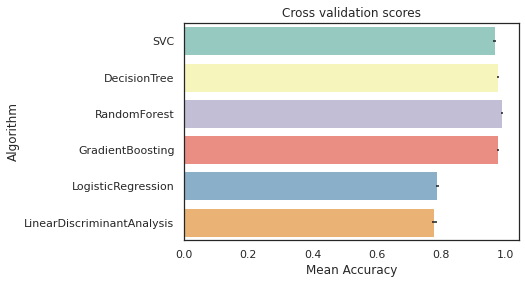

In [22]:
# Test and select differents algorithms 
random_state = 56
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree",
"RandomForest","GradientBoosting","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

It's clear that the three best performed models are DecisionTree, RandomForest and GradientBoosting. 

_Normally the next step is parameter tunning for these best models, but we have limited features in this datasets, I simply set the max_depth parameters for the trees to be 30, which means almost no restriction, the tree will develop to the end of prune._

__Model Traning using Training Set__

In [23]:
# Decision Tree
dtc = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=56)
dtc.fit(X_train, y_train)
# Random Forest
rfc = RandomForestClassifier(max_depth=30, random_state=56)
rfc.fit(X_train, y_train)
# GradientBoosting
gbc = GradientBoostingClassifier(max_depth=30, random_state=56)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=30, random_state=56)

__Model Evaluation using Test Set__

In [24]:
# Evaluate using confusion matrix and TP/FP
cm = confusion_matrix(y_test, dtc.predict(X_test))
print("DecisionTree CM: \n", cm)
dtc_acc = (cm.ravel()[0] + cm.ravel()[3]) / sum(cm.ravel())
dtc_TP = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
dtc_FP = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
dtc_precision = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[1])
dtc_recall = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2])

cm = confusion_matrix(y_test, rfc.predict(X_test))
print("RandomForest CM: \n", cm)
rfc_acc = (cm.ravel()[0] + cm.ravel()[3]) / sum(cm.ravel())
rfc_TP = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
rfc_FP = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
rfc_precision = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[1])
rfc_recall = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2])

cm = confusion_matrix(y_test, gbc.predict(X_test))
print("GradientBoosting CM: \n", cm)
gbc_acc = (cm.ravel()[0] + cm.ravel()[3]) / sum(cm.ravel())
gbc_TP = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
gbc_FP = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
gbc_precision = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[1])
gbc_recall = cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2])

DecisionTree CM: 
 [[2248   14]
 [  67  671]]
RandomForest CM: 
 [[2257    5]
 [  23  715]]
GradientBoosting CM: 
 [[2222   40]
 [  26  712]]


In [25]:
# Accuracy, True Positve Rate and False Postitive Rate
data = {
    'Decision Tree': [dtc_acc, dtc_TP, dtc_FP, dtc_precision, dtc_recall],
    'Random Forest': [rfc_acc, rfc_TP, rfc_FP, rfc_precision, rfc_recall],
    'Gradient Boosting': [gbc_acc, gbc_TP, gbc_FP, gbc_precision, gbc_recall]
}
pd.DataFrame(data = data, index = ['Accuracy', 'TPR', 'FPR', 'Precision', 'Recall']).transpose()

,Accuracy,TPR,FPR,Precision,Recall
Decision Tree,0.973000,0.909214,0.006189,0.979562,0.909214
Random Forest,0.990667,0.968835,0.002210,0.993056,0.968835
Gradient Boosting,0.978000,0.964770,0.017683,0.946809,0.964770


From the chart above, it's clear that Random Forest performs the best, with a 99% accuracy and 96.6% TPR.

## Part 4) Results and Discussion

In the analysis above, Random Forest performed the best on all three metrics. So we use it as our prediction model. In this final part, we will see which features are the most important of this model, and compare them to the findings from EDA. Basing on that, some recommendations would be made to improve the employee retention rate.

__Feature Importance__

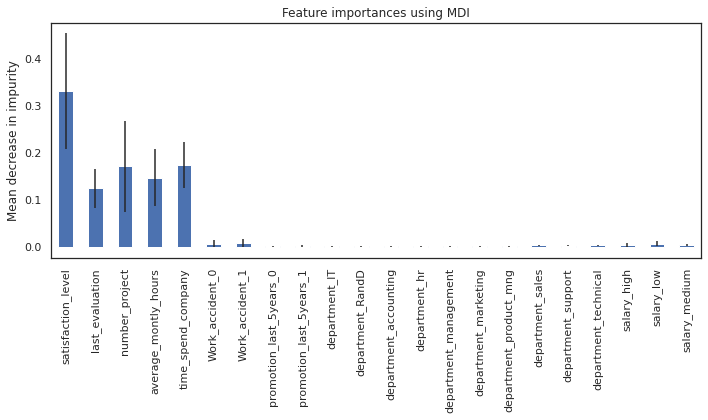

In [26]:
# feature importance based on mean decrease in impurity
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, figsize=(10,6))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

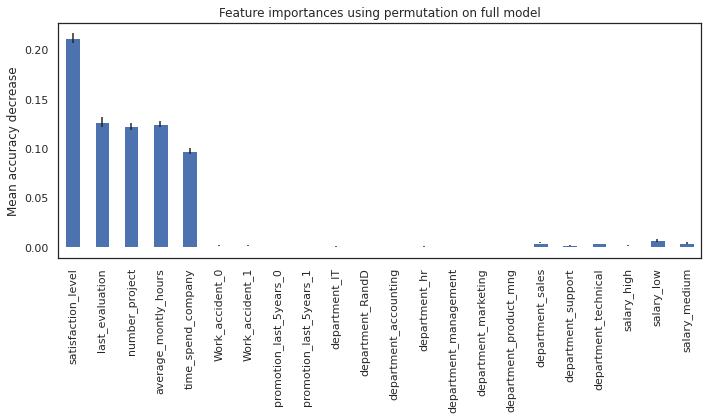

In [27]:
# feature importance based on feature permutaion
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, figsize=(10,6))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Both methods show that that the most important features in modeling is the satisfaction level, followed by evaluation score, number of project and average monthly hours (in the EDA part we have seen that these three are highly correlated). The time spent at the company also plays an important role.

__Recommendations__

Combining the EDA and the modeling results, here are some recommendations I would give to company ABC to improve its employee retention rate:
1. __The most important thing is to improve employees' satisfaction with the company. To accomplish this, the best practice is to give promotions and increase the salary.__ Deliberately designing work accidents may also improve satisfaction but I do NOT recommend it. __In saying that, do not make employees too comfortable.__ Those who are too satisfied also left, maybe for them, this job is not challenging enough.
2. __If the company wants their most experienced employees stay, they should give them less work burben and promotion.__
3. __Try not to give either too much or too little work to the employee.__ Work burden is highly related to the retention rate, and it's shown that those who have too much or too little work tend to leave and those who have an appropriate workload stay.